<a href="https://colab.research.google.com/github/s1250103/Public_mori-lab/blob/confirm_label_noize_for_cm_data/eras/confirm_label/clean_KTH_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

このシステムは以下のような変換を意図している: <br>
  データ→[このシステム]→(変換されたデータ, 教師ラベル) <br>
ここで、
*   データとは：動画を表現した形式の複数
*   変換されたデータとは：ニューラルネットワークの入力として適した形式になっているデータ
*   教師ラベルとは：教師あり学習における正解ラベルのこと。

2021/01/19：森谷亮太




# 環境設定

In [3]:
#@title 絶対条件（実験の条件に関わり最も重要）
LABEL_NOISE_RATE = 0
CLASSES = ["walking", "boxing", "running", "handwaving"]

rate_of_testdata = 0.3

class video_format:
  name = "video_format"
  # サンプリングされたCMデータの仕様
  playtime = "15秒"
  displaysize = "(any, any, RGB)"
  videoformat = "any"
  # モデルが扱うCMデータ(上のようなデータは、下のように変換される)
  HEIGHT = 45
  WIDTH = 80
  FRAME_SIZE = 30
  COLOR = "RGB"
  FPS = "2 (FRAME_SIZE / playtime)" # 定義ではなく上から導かれた値

In [4]:
dataPath = "/content/drive/MyDrive/colab/KTH_datasets"

In [77]:
#@title import
# file dealing
import os
from os import path
import shutil
from google.colab import drive
# data dealing
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
# process deasing
import gc

# other
import re
import requests

In [71]:
def beep():
  from google.colab import output
  output.eval_js('new Audio(\
"https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg")\
.play()') 

In [74]:
def send_line_notify(notification_message):
    """
    LINEに通知する
    """
    line_notify_token = 'cHdELzsau6ve8hNVL3FxPz65Jdyquzuj2kd021u8q1L'
    line_notify_api = 'https://notify-api.line.me/api/notify'
    headers = {'Authorization': f'Bearer {line_notify_token}'}
    data = {'message': notification_message}
    requests.post(line_notify_api, headers = headers, data = data)

# データの変換とラベリング

In [6]:
def connect_to_gdrive():
  # gdrive 接続
  if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
  else:
    print("Already confirm")

def create_and_connect_to_desk():
  # colab テンポラリディレクトリの作成
  desk = '/content/desk'
  if not os.path.exists(desk):
    os.mkdir(desk)
  print("Created at /content/desk")
  return desk



In [7]:
connect_to_gdrive()
desk = create_and_connect_to_desk()

Already confirm
Created at /content/desk


In [8]:
if os.path.isdir(dataPath):
  print("exist the path")
else:
  print("no such path")


exist the path


概要

In [104]:
accumulated_value_for_cleaned_data = []

# into each class
for each_class in CLASSES:
  print("clean the class : ", each_class)
  each_class_path = path.join(dataPath, each_class)
  if os.path.isdir(each_class_path):
    print("|------------- exist the path : ", each_class_path)
    files_in_each_class = os.listdir(each_class_path)
    size_of_each_class = len(files_in_each_class)
    accumulated_value_for_cleaned_data.append(size_of_each_class)
    print("____|------------ exist", size_of_each_class, "files in the class & accumulated value is", sum(accumulated_value_for_cleaned_data))

  else:
    exit(0)
  print("===========================================================================")

clean the class :  walking
|------------- exist the path :  /content/drive/MyDrive/colab/KTH_datasets/walking
____|------------ exist 100 files in the class & accumulated value is 100
clean the class :  boxing
|------------- exist the path :  /content/drive/MyDrive/colab/KTH_datasets/boxing
____|------------ exist 100 files in the class & accumulated value is 200
clean the class :  running
|------------- exist the path :  /content/drive/MyDrive/colab/KTH_datasets/running
____|------------ exist 100 files in the class & accumulated value is 300
clean the class :  handwaving
|------------- exist the path :  /content/drive/MyDrive/colab/KTH_datasets/handwaving
____|------------ exist 100 files in the class & accumulated value is 400


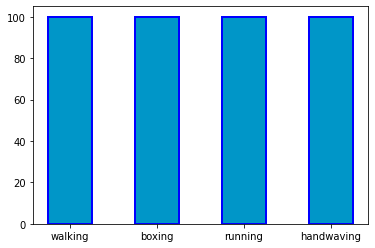

walking : 100
boxing : 100
running : 100
handwaving : 100
__________________________________________________________
Sum :  400


In [105]:
import matplotlib.pyplot as plt
 
left = [1, 2, 3, 4]
height = accumulated_value_for_cleaned_data

labels = CLASSES
 
plt.bar(left, height, width=0.5, color='#0096c8',
        edgecolor='b', linewidth=2, tick_label=labels)

plt.savefig("img.png")
plt.show()

for i, each_label in enumerate(labels):
  print(each_label, ":", accumulated_value_for_cleaned_data[i])
print("__________________________________________________________")
print("Sum : ", sum(accumulated_value_for_cleaned_data))

In [117]:
import math
import cv2
def makeupVideo(video_path):
  format1=video_format()
  video = cv2.VideoCapture(video_path)
  framesize = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
  cutTiming = math.floor(framesize / format1.FRAME_SIZE)
  cutTail = cutTiming * format1.FRAME_SIZE
  normalizedFrames = []
  count = 0
  # フレーム３０枚分を１つの動画から間伐する
  while count <= cutTail - 1:
    IO, frame = video.read()
    if (count % cutTiming) == 0: 
      if not IO:
        print("error") 
        send_line_notify("error")
        return False, False, False

      else: 
        fixedFrame = cv2.resize(frame, dsize=(format1.WIDTH, format1.HEIGHT))
        fixedFrame = fixedFrame.flatten().astype(np.float32)/255.0
        check(fixedFrame) # デバッグ用
        normalizedFrames.append(fixedFrame)
    else:
      pass
    count += 1

  normalizedFrames = np.array(normalizedFrames)
  normalizedFrames = normalizedFrames.flatten()
  return True, normalizedFrames, framesize

def check(image):
  if debug == True:
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
  else:
    return

In [118]:
%%time
# into each class
debug = False
cleaned_data_contener = []
label_contener = []
frame_sizes = []
for counter_class, each_class in enumerate(CLASSES):
  print("clean the files in the class : ", each_class)
  each_class_path = path.join(dataPath, each_class)
  if os.path.isdir(each_class_path):
    print("|------------- the path : ", each_class_path)
    files_in_each_class = os.listdir(each_class_path)
    size_of_each_class = len(files_in_each_class)
    # into each file
    for each_file in files_in_each_class:
      if re.match(r".*\..*", each_file,):
        print("________|------------ start to clean: ", each_file)
        each_file_path = path.join(each_class_path, each_file)
        if path.exists(each_file_path):
          print("________________|------------- confirm the file.")
          IO, cleaned_data, frame_size = makeupVideo(each_file_path)
          if IO:
            print("________________|------------- the frame size:", frame_size)
            cleaned_data_contener.append(cleaned_data)
            frame_sizes.append(frame_size)
            label_contener.append(counter_class)
            print("________________|------------- finish the treatment.")
          else:
            accumulated_value_for_cleaned_data[counter_class] -= 1
            print("________________|------------- skip by the file broken")
        else:
          print("________________|------------- can not confirm the file.")
          exit(0)
      else:
        print("________|------------ ignore the system file")
      # break
  else:
    exit(0)
print("===========================================================================")

print("finish all")
#/for


clean the files in the class :  walking
|------------- the path :  /content/drive/MyDrive/colab/KTH_datasets/walking
________|------------ start to clean:  person01_walking_d1_uncomp.avi
________________|------------- confirm the file.
________________|------------- the frame size: 555
________________|------------- finish the treatment.
________|------------ start to clean:  person01_walking_d2_uncomp.avi
________________|------------- confirm the file.
________________|------------- the frame size: 675
________________|------------- finish the treatment.
________|------------ start to clean:  person01_walking_d3_uncomp.avi
________________|------------- confirm the file.
________________|------------- the frame size: 950
________________|------------- finish the treatment.
________|------------ start to clean:  person01_walking_d4_uncomp.avi
________________|------------- confirm the file.
________________|------------- the frame size: 565
________________|------------- finish the tr

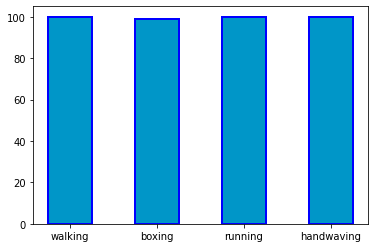

walking : 100
boxing : 99
running : 100
handwaving : 100
__________________________________________________________
Sum :  399


In [115]:
height = accumulated_value_for_cleaned_data
plt.bar(left, height, width=0.5, color='#0096c8',
        edgecolor='b', linewidth=2, tick_label=labels)

plt.savefig("img.png")
plt.show()

for i, each_label in enumerate(labels):
  print(each_label, ":", accumulated_value_for_cleaned_data[i])
print("__________________________________________________________")
print("Sum : ", sum(accumulated_value_for_cleaned_data))

# データをエクスポート

In [120]:
def save_data(set_of_npdata, saveName):
  np.savez(os.path.join(desk, saveName), *set_of_npdata)

In [121]:
if len(cleaned_data_contener) == len(label_contener):
  save_data(cleaned_data_contener, "Data_of_KTH")
  save_data(label_contener, "Label_of_KTH")

In [122]:
shelf = '/content/drive/MyDrive/colab/cleaned_detasets'
book = "KTH"
shelf_book = os.path.join(shelf, book)
if not os.path.exists(shelf_book):
  os.mkdir(shelf_book)

In [123]:
wants_paths = [
"/content/desk/Data_of_KTH.npz",
"/content/desk/Label_of_KTH.npz",
]

for want in wants_paths:
  shutil.copy2(
      want,
      shelf_book
  )